In [140]:
import torch
import torchvision.transforms as T
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from torch import tensor

In [141]:

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("This is an informational message")
logging.warning("This is a warning message")


DEBUG:root:test
INFO:root:This is an informational message


In [142]:
# You can downlaod the dataset using: kaggle competitions download -c imagenet-object-localization-challenge

In [143]:
IMAGE_SIZE = 128
CENTER_SIZE = 64
BATCH_SIZE = 1500

# Utils

In [144]:
import math
def display_image(img):
        with torch.no_grad():
                img = img.permute((1, 2, 0))
                plt.imshow(img.cpu().numpy())
                plt.show()

def display_images(imgs, images_per_row=2, title=None):
        with torch.no_grad():
                rows = math.ceil(len(imgs) / images_per_row)
                fig = plt.figure(figsize=(images_per_row*2, rows*2))
                if title:
                        fig.suptitle(title, fontsize=10)
                for i, img in enumerate(imgs):
                        plt.subplot(rows, images_per_row, i+1)
                        plt.axis('off')
                        plt.tight_layout()
                        img = img.permute((1, 2, 0))
                        plt.imshow(img.cpu().numpy())
                plt.show()

def get_center_of_image(img, size=64):
        return T.CenterCrop((size, size))(img)

def get_img_without_center(img, size=64):
        left = (IMAGE_SIZE - CENTER_SIZE) // 2
        right = (IMAGE_SIZE - CENTER_SIZE) // 2 + CENTER_SIZE
        if(len(img.shape) == 3):
                img[ :, left:right, left:right ] = 0
        elif(len(img.shape) == 4):
                img[:, :, left:right, left:right ] = 0
        else:
                raise RuntimeError("Wrong shape to get_img_without_center!")
                
        return img

class CenterImageRemoval(object):
    def __init__(self, image_size, center_size):
        self.image_size = image_size
        self.center_size = center_size
        
    def __call__(self, img):
        left = (self.image_size - self.center_size) // 2
        right = (self.image_size - self.center_size) // 2 + self.center_size

        if(len(img.shape) == 3):
                assert img.shape[1] == img.shape[2] == self.image_size
                img[ :, left:right, left:right ] = 0
        elif(len(img.shape) == 4):
                assert img.shape[2] == img.shape[3] == self.image_size
                img[:, :, left:right, left:right ] = 0

        return img

class AddImageCenter(object):
    def __init__(self, image_size, center_size):
        self.image_size = image_size
        self.center_size = center_size
        
    def __call__(self, img, center):
        assert center.shape[1] == center.shape[2] == self.center_size

        left = (self.image_size - self.center_size) // 2
        right = (self.image_size - self.center_size) // 2 + self.center_size

        if(len(img.shape) == 3):
                assert img.shape[1] == img.shape[2] == self.image_size
                img[ :, left:right, left:right ] = center
        elif(len(img.shape) == 4):
                assert img.shape[2] == img.shape[3] == self.image_size
                img[:, :, left:right, left:right ] = center
        return img

class JointRandomResizeCrop(object):
    def __init__(self, size: int, minimum_scale, maximum_scale):
        """
        params:
            size (int) : size of the center crop
        """
        self.size = size
        self.min_scale = minimum_scale
        self.max_scale = maximum_scale
        
    def __call__(self, img, target):
        scale = (self.max_scale - self.min_scale)*random.random() + self.min_scale
        _, height, width = img.shape
        new_h, new_w = int(height*scale), int(width*scale)

        target = target.reshape((1, height, width))
        resized_img = T.functional.resize(img,  [new_h, new_w])
        resized_target = T.functional.resize(target, [new_h, new_w])
        crop_size = min(self.size, new_h, new_w)
        top = random.randint(0, new_h - crop_size)
        left = random.randint(0, new_w - crop_size)
        resized_img = T.functional.crop(resized_img, top, left, crop_size, crop_size)
        resized_target = T.functional.crop(resized_target, top, left, crop_size, crop_size)

        resized_img = T.functional.resize(resized_img, size=(self.size, self.size))
        resized_target = T.functional.resize(resized_target, size=(self.size, self.size))
        resized_target = resized_target.reshape((self.size, self.size))

        return (resized_img, resized_target)
    
def save_model(encoder, decoder, epoch, optimizer, path):
	state = {
    'epoch': epoch,
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'optimizer': optimizer.state_dict(),
	}
	torch.save(state, path)


def load_model(encoder, decoder, optimizer, path):
	state = torch.load(path)
	encoder.load_state_dict(state["encoder"])
	decoder.load_state_dict(state["decoder"])
	optimizer.load_state_dict(state["optimizer"])
	return state["epoch"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloading

In [145]:
train_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.RandomHorizontalFlip(p=0.5),
    T.ConvertImageDtype(torch.float32),
])

val_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
])

# extra transformation not applied to ground truth images
non_gt_extra_transforms = T.Compose([
    CenterImageRemoval(IMAGE_SIZE, CENTER_SIZE),
])

sanity_transforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.CenterCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
])

In [169]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from IPython.display import clear_output

class CustomDataSet(Dataset):
    def __init__(self, root_dir, classes, transform=None, non_gt_extra_transforms=None, training_split=0.8, is_train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.non_gt_extra_transforms = non_gt_extra_transforms

        dirs = np.array(sorted(os.listdir(root_dir)))[classes]
        # print(dirs.shape)
        # train_split = int(dirs.shape[0]*training_split)
        # dirs = dirs[0:train_split]
        # print(dirs.shape)

        self.images = []
        self.cache = {}

        self.is_train = is_train
        for i, dir in enumerate(dirs):
            imgs = sorted(os.listdir(os.path.join(self.root_dir, dir)))
            train_split = int(len(imgs)*training_split)
            if is_train:
                imgs = imgs[0:train_split]
            else:
                imgs = imgs[train_split:]
            for img in imgs:
                self.images.append((os.path.join(self.root_dir, dir, img), classes[i]))
    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name, class_label = self.images[idx]
        image = None

        if img_name not in self.cache:
            self.cache[img_name] = Image.open(img_name).convert('RGB')
        image = self.cache[img_name]


        if self.transform:
            transformed_image = self.transform(image)
        else:
            transformed_image = None

        gt_image = torch.clone(transformed_image)

        if non_gt_extra_transforms:
            transformed_image = non_gt_extra_transforms(transformed_image)

        return transformed_image, gt_image, class_label


# Create the dataset

# classes =  [538, 980]
# classes =  [538, 980, 971]
classes =  [
            858, # Tile Roof
            # 852, # Tennis Ball
            # 980 # Volcano
            ]

DATASET_PATH = '/pub2/imagenet/ILSVRC/Data/CLS-LOC/train'
# Due to the way the dataset is strucutred, I can't use the offical validation images provided
# Therefore, I'm splitting the provided training_split from the dataset, 90% for training, and 10% for validation

train_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=train_tranforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=classes,
                                      is_train=True,
                                      training_split=0.9
                                      )

validation_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=val_tranforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=classes,
                                      is_train=False
                                      )

# Like the training dataset but only has 1 image
sanity_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=sanity_transforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=classes,
                                      is_train=True,
                                      training_split=0.9
                                      )
sanity_dataset = torch.utils.data.Subset(sanity_dataset, [1])


In [170]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
sanity_loader = DataLoader(sanity_dataset, batch_size=1, shuffle=True)

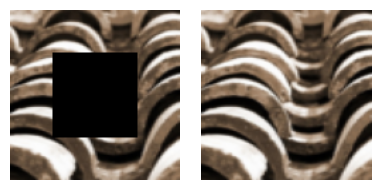

In [177]:
sample_batch = next(iter(train_loader))
sample_cutout, sample_gt, sample_class_idx = sample_batch

display_images([sample_cutout[0], sample_gt[0]])

# Network

In [178]:
LATENT_SPACE_DIM = 4000
HIDDEN_LAYER_SIZE = 64

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        # self.conv_t1 = nn.ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=0 )
        # self.conv_1 = nn.Conv2d(128, 90, kernel_size=5, padding=1)
        # self.batch_norm_1 = nn.BatchNorm2d(90)
        # self.conv_2 = nn.Conv2d(90, 128, kernel_size=5, padding=1)
        # self.batch_norm_2 = nn.BatchNorm2d(128)
        # self.conv_t2 = nn.ConvTranspose2d(128, 3, kernel_size=5, stride=4, padding=0, output_padding=0 )
        # self.conv_final = nn.Conv2d(3, 3, 1)
        # self.num_classes = 5

        # (128, 128) -> (64, 64)
        self.conv1 = nn.Conv2d(3, HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  

        # (64, 64) -> (32, 32)
        self.conv2 = nn.Conv2d(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)

        # (32, 32) -> (16, 16)
        self.conv3 = nn.Conv2d(HIDDEN_LAYER_SIZE, 2 * HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  # 16x16 => 8x8

        # (16, 16) -> (8, 8)
        self.conv4 = nn.Conv2d(2 * HIDDEN_LAYER_SIZE, 4 * HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)

        # (8, 8) -> (4, 4)
        self.conv5 = nn.Conv2d(4 * HIDDEN_LAYER_SIZE, 8*HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  # 8x8 => 4x4
        self.flatten = nn.Flatten()

        # (4, 4) -> (Latence_Space_Dim)
        self.linear = nn.Linear(4*4 * (8* HIDDEN_LAYER_SIZE), LATENT_SPACE_DIM)

    def forward(self, inp):
        # print(inp.shape)
        inp = F.leaky_relu(self.conv1(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv2(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv3(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv4(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv5(inp))
        inp = self.flatten(inp)

        # print(inp.shape)
        inp = F.leaky_relu(self.linear(inp))
        # Encoder
        # original_inp = inp
        # inp = self.resnet.conv1(inp)
        # inp = self.resnet.bn1(inp)
        # inp = self.resnet.relu(inp)
        # skip = inp.clone()
        # inp = self.resnet.maxpool(inp)
        # inp = self.resnet.layer1(inp)
        # inp = self.resnet.layer2(inp)
        # inp = self.resnet.layer3(inp)
        # inp = self.resnet.layer4(inp)
        # print("fully encoded shape is", inp.shape)
        return inp

In [150]:
# encoder = Encoder()
# encoder = encoder.to(device)
# encoder(sample_cutout[0].to(device).unsqueeze(0)).shape

In [179]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

        # (LATENT_SPACE_DIM) -> (4 , 4)
        self.linear = nn.Linear(LATENT_SPACE_DIM, 4*4*8*HIDDEN_LAYER_SIZE)

        # (4, 4) -> (8 , 8)
        self.conv_t1 = nn.ConvTranspose2d(8*HIDDEN_LAYER_SIZE, 4*HIDDEN_LAYER_SIZE, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(4*HIDDEN_LAYER_SIZE)

        # (8, 8) -> (16, 16)
        self.conv_t2 = nn.ConvTranspose2d(4*HIDDEN_LAYER_SIZE, 2*HIDDEN_LAYER_SIZE , kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(2*HIDDEN_LAYER_SIZE)

        # (16, 16) -> (32, 32)
        self.conv_t3 = nn.ConvTranspose2d(2*HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(HIDDEN_LAYER_SIZE)

        # (32, 32) -> (64, 64)
        self.conv_t4 = nn.ConvTranspose2d(HIDDEN_LAYER_SIZE, 3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        # self.batch_norm_4 = nn.BatchNorm2d(3)

        # self.conv = nn.Conv2d(HIDDEN_LAYER_SIZE, 3, kernel_size=4, stride=1, padding=1)
        # self.conv_t5 = nn.ConvTranspose2d(LATENT_SPACE_DIM // 64, 32, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=1)
        # self.batch_norm_5 = nn.BatchNorm2d(32)

        # nn.Upsample(scale_factor = 2, mode='bilinear'),
        #                   nn.ReflectionPad2d(1),
        #                   nn.Conv2d(ngf * mult, int(ngf * mult / 2),
        #                                      kernel_size=3, stride=1, padding=0)



    def forward(self, inp):
        inp = self.linear(inp)
        # Reshape back to image size
        # inp.shape[0] gives the batch size
        # We want a 4x4 image shape 
        inp = inp.reshape(inp.shape[0], -1, 4, 4) 
        # print(inp.shape)

        inp = self.conv_t1(inp)
        inp = self.batch_norm_1(inp)
        inp = F.relu(inp)
        # print(inp.shape)

        inp = self.conv_t2(inp)
        inp = self.batch_norm_2(inp)
        inp = F.relu(inp)
        # print(inp.shape)

        inp = self.conv_t3(inp)
        inp = self.batch_norm_3(inp)
        inp = F.relu(inp)
        # print("here 1", inp.shape)

        inp = self.conv_t4(inp)
        # inp = self.batch_norm_4(inp)
        # inp = F.relu(inp)
        # print("here 2", inp.shape)

        # inp = self.conv_t5(inp)
        # inp = self.batch_norm_5(inp)
        # inp = F.relu(inp)
        # print(inp.shape)

        # inp = self.conv(inp)
        inp = torch.sigmoid(inp)
        
        # print("image size after decode is", inp.shape)
        # inp = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(inp)

        return inp

In [180]:
def predict_fill_area_for_img(img, encoder, decoder):
	img = img.to(device)
	img = img.unsqueeze(0)
	embedding = encoder(img)
	out = decoder(embedding)[0]
	return out.cpu()

In [153]:
# decoder = Decoder()
# decoder = decoder.to(device)

# sample_untrained_out = predict_fill_area_for_img(sample_cutout[0], encoder, decoder)
# display_images([sample_untrained_out, sample_gt[0]])

# Train  

In [181]:
from tqdm import tqdm


In [220]:
def get_optimizer(encoder, decoder):
	optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
	return optim


loss_fn = nn.MSELoss()

In [221]:
def get_infilled_image(img, encoder, decoder):
		fill_area = predict_fill_area_for_img(img, encoder, decoder)
		with_center = AddImageCenter(IMAGE_SIZE, CENTER_SIZE)(torch.clone(img), fill_area)
		return with_center


In [222]:

def show_sample_photos(encoder, decoder, title="Sample Batch Photos",):
	images = []
	for sample_image_index in range(0,3):
		cutout_image = sample_cutout[sample_image_index]
		predicted_image = get_infilled_image(cutout_image, encoder, decoder)
		images += [predicted_image, sample_gt[sample_image_index]]
	display_images(images, images_per_row=2, title=title)

# show_sample_photos()


In [223]:
def get_val_loss(encoder, decoder):
	with torch.no_grad():
		total_loss = 0
		number_of_images = len(val_loader)
		for batch in val_loader:
				images, gt_images, _ = batch
				images = images.to(device)
				gt_images = gt_images.to(device)

				embeded_images = encoder(images)
				decoded_images = decoder(embeded_images)
				total_loss += loss_fn(get_center_of_image(gt_images), decoded_images).item()
	return total_loss / number_of_images

In [186]:
def display_loss_history_graph(train_loss_history, val_loss_history, title="Training and Validation Loss" ):
	train_loss_history = np.array(train_loss_history)
	val_loss_history = np.array(val_loss_history)

	plt.plot(train_loss_history[:, 0], train_loss_history[:, 1], label="Training Loss")
	plt.plot(val_loss_history[:, 0], val_loss_history[:, 1], label="Validation Loss")

	plt.title(title)
	plt.xlabel("Epochs")
	plt.ylabel("Loss")
	plt.legend()

In [224]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def do_training(epochs, train_loss_history, val_loss_history, data_loader, optim, encoder, decoder, val_interval = 2, should_save = False):
	# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, verbose=True, T_max=10)
	# scheduler2 = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=10, verbose=True)
	best_val = 999999
	for epoch in range(epochs):
		encoder = encoder.to(device)
		decoder = decoder.to(device)
		encoder.train()
		decoder.train()
		
		epoch_loss = 0
		total_number_of_images = len(data_loader)
		pbar = tqdm(enumerate(data_loader), total=total_number_of_images)
		for i, batch in pbar:
			images, gt_images, _ = batch

			images = images.to(device)
			gt_images = gt_images.to(device)

			optim.zero_grad()

			embedded_images = encoder(images)
			decoded_images = decoder(embedded_images)

			loss = loss_fn(get_center_of_image(gt_images), decoded_images)
			loss.backward()
			optim.step()
			epoch_loss += loss.item()

		epoch_loss /= total_number_of_images
		train_loss_history.append([epoch, epoch_loss])
		if epoch % val_interval == 0:
			val_loss = get_val_loss(encoder, decoder)
			print(f"Val Loss: {val_loss}")
			val_loss_history.append([epoch, val_loss])
			if val_loss < best_val and should_save:
				save_model(encoder, decoder, epoch, optim, f"./models/model-{epoch}-{val_loss}.pth")
				best_val = val_loss
			# scheduler2.step(val_loss)

		if epoch % 5 == 0:
			clear_output()
			display_loss_history_graph(train_loss_history, val_loss_history, title="Sanity Training and Validation Loss")
			plt.show()


		# scheduler.step()
		print(f"Epoch Loss: {epoch_loss}")

## Do Sanity Check with single image dataset 

In [ ]:
sanity_enc = Encoder()
sanity_dec = Decoder()
sanity_optim = get_optimizer(sanity_enc, sanity_dec)

sanity_train_loss_history = []
sanity_val_loss_history = []
do_training(
	epochs=100, 
	train_loss_history=sanity_train_loss_history, 
	val_loss_history=sanity_val_loss_history, 
	data_loader=sanity_loader, 
	optim=sanity_optim,
	encoder=sanity_enc, 
	decoder=sanity_dec,
	)

sanity_img, sanity_gt, sanity_class = next(iter(sanity_loader))
display_images([sanity_img[0], get_infilled_image(sanity_img[0], sanity_enc, sanity_dec), sanity_gt[0]], images_per_row=3)

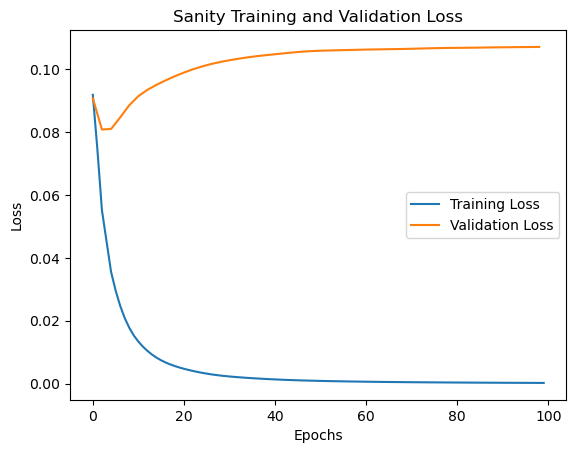

In [207]:
display_loss_history_graph(sanity_train_loss_history, sanity_val_loss_history, title="Sanity Training and Validation Loss")

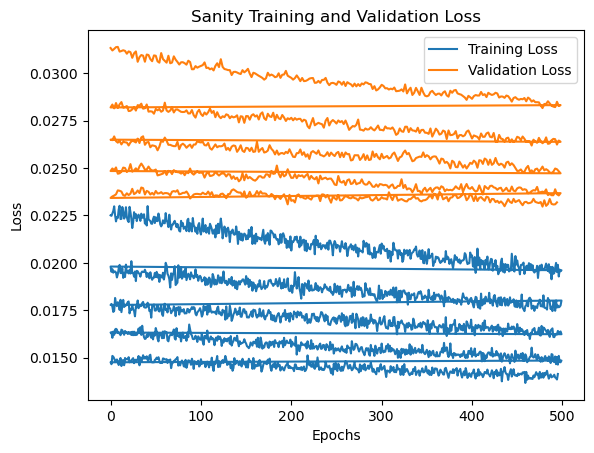

Epoch Loss: 0.014135396108031273


 ... (more hidden) ...

 ... (more hidden) ...


Val Loss: 0.02326832339167595
Epoch Loss: 0.014049772173166275


 ... (more hidden) ...


Epoch Loss: 0.013857885263860226


 ... (more hidden) ...


Val Loss: 0.023234300315380096
Epoch Loss: 0.014030089601874352


 ... (more hidden) ...

Epoch Loss: 0.013829778879880905


In [236]:
# enc = Encoder()
# dec = Decoder()
# optim = get_optimizer(enc, dec)

# enc = nn.DataParallel(enc)
# dec = nn.DataParallel(dec)

# train_loss_history = []
# val_loss_history = []
do_training(
	epochs=500, 
	train_loss_history=train_loss_history, 
	val_loss_history=val_loss_history, 
	data_loader=train_loader, 
	optim=optim,
	encoder=enc, 
	decoder=dec,
	should_save=False
	)

In [ ]:
display_loss_history_graph(sanity_train_loss_history, sanity_val_loss_history, title="Sanity Training and Validation Loss")

In [272]:
img, img_gt, _ = next(iter(val_loader))

In [258]:
proc_train_loss_history = []
proc_val_loss_history = []

offset = 0
for i, val in train_loss_history:
	proc_train_loss_history.append([i + offset, val])
	if i == 499:
		offset += 500

offset = 0
for i, val in val_loss_history:
	proc_val_loss_history.append([i + offset, val])
	if i == 498:
		offset += 500

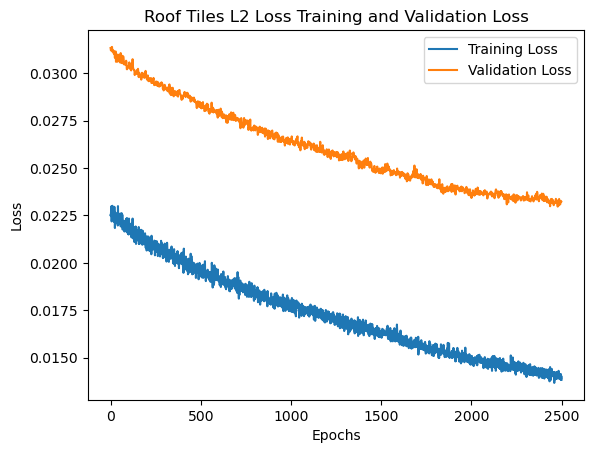

In [266]:
display_loss_history_graph(proc_train_loss_history, proc_val_loss_history, title="Roof Tiles L2 Loss Training and Validation Loss")

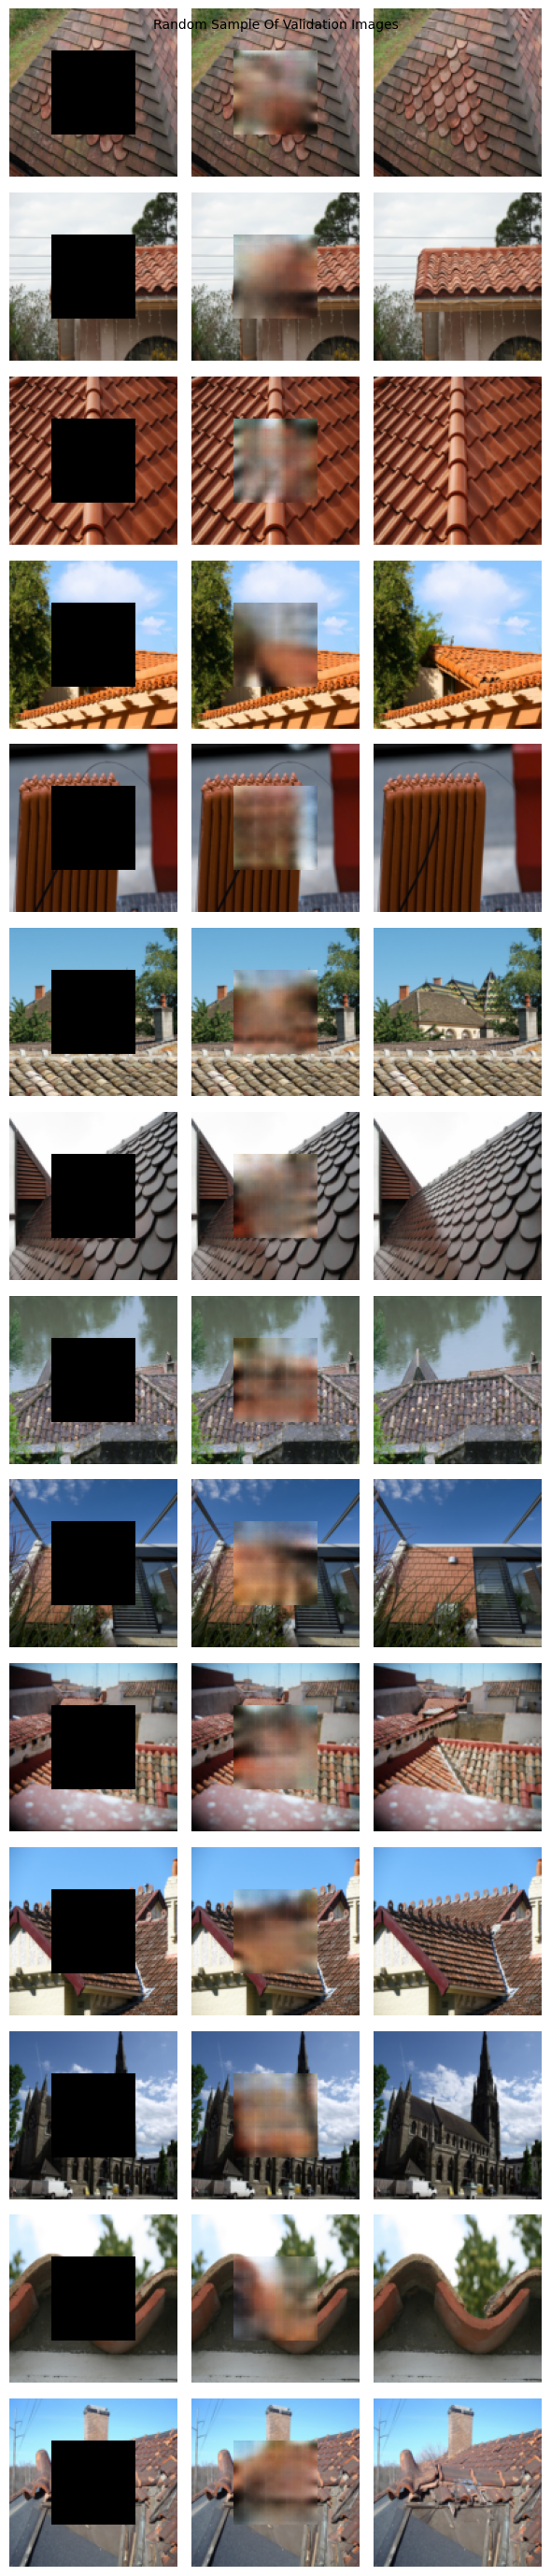

In [277]:
indexes = [0, 3, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 30, 31 ]

images = []
for index in indexes:
	images += [img[index], get_infilled_image(img[index], enc, dec), img_gt[index]]

display_images(images, images_per_row=3, title="Random Sample Of Validation Images")

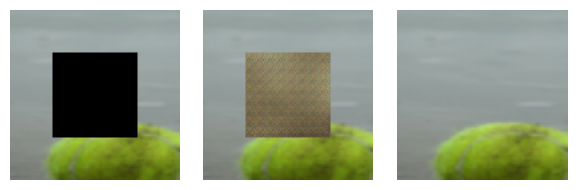

In [ ]:
index = 20
display_images([img[index], get_infilled_image(img[index], enc, dec), img_gt[index]], images_per_row=3)

In [235]:
save_model(enc, dec, 100, optim, path="./roof-model-3000-epochs.pth")


In [ ]:
load_model(encoder, decoder, optim, path="test_model.pth")